In [82]:
# !pip install pystan
# !pip install fbprophet
# !pip install plotly
# !pip install ipywidgets
"""
ref: prophet docs
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import json
from fbprophet.serialize import model_to_json, model_from_json


# State %-production share

# MAHARASHTRA 29.59
# MADHYA PRADESH 15.16
# KARNATAKA 13.64
# GUJARAT 6.42
# BIHAR 6.25
# RAJASTHAN 4.80
# ANDHRA PRADESH 5.02
# source: http://agricoop.gov.in/sites/default/files/Monthly%20Report%20on%20Onion%20for%20May%2C%202018.pdf



$$y(t)=g(t)+s(t)+h(t)+\epsilon _t$$
$$g(t)=\frac{C}{1+}$$
$$s(t)=\sum_{n=1}^{N}\bigg(a_n \cos\Big(\frac{2\pi nt}{P}\Big) + b_n \sin\Big(\frac{2\pi nt}{P}\Big)\bigg)$$
$$$$

```

In [83]:
df = pd.read_csv('mod_data.csv')
# df = df.drop(['Unnamed: 0', 'DISTRICT', 'MARKET', 'COMMODITY', 'VARIETY', 'GRADE',
#        'MIN', 'MAX'], axis= 1)
df = df.drop(['Unnamed: 0'], axis= 1)
df['DATE'] = df['DATE'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
# df['y'] = df['MODAL'].apply(lambda x: int(x))
df.columns = ['ds','y']
df = df.sort_values(by=['ds'])
# df = pd.read_csv('full_onion_data.csv')
# df = df.drop(['Unnamed: 0', 'DISTRICT', 'MARKET', 'COMMODITY', 'VARIETY', 'GRADE',
#        'MIN', 'MAX'], axis= 1)
# df['ds'] = df['DATE'].apply(lambda x: datetime.strptime(x, "%d %b %Y"))
# df['y'] = df['MODAL'].apply(lambda x: int(x))
# df = df.sort_values(by=['ds'])

In [84]:
df.head()

,ds,y
0,2010-01-01,1250.00
1,2010-01-02,1256.25
2,2010-01-03,1262.50
3,2010-01-04,1193.75
4,2010-01-05,1125.00


In [85]:
df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [86]:
df.head()

,ds,y
0,2010-01-01,1250.00
1,2010-01-02,1256.25
2,2010-01-03,1262.50
3,2010-01-04,1193.75
4,2010-01-05,1125.00


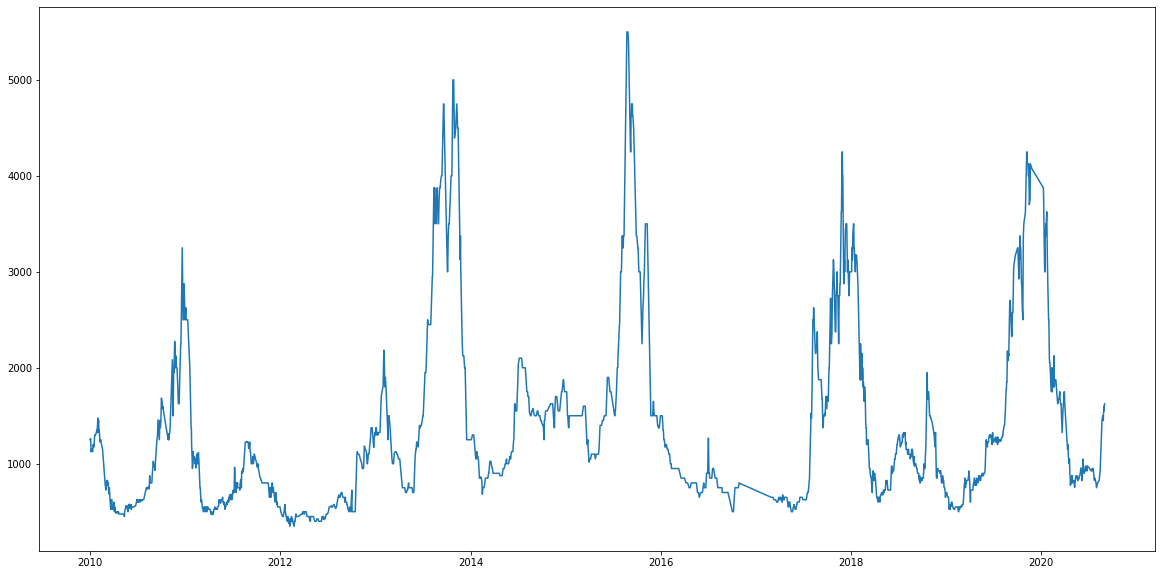

In [87]:
plt.figure(figsize=(20,10))
plt.plot(df['ds'], df['y'])
plt.show()

# plt.figure(figsize=(20,10))
# df.plot()
# plt.show()

In [88]:
m = Prophet()
# Prophet.add_country_holidays(m, "India")
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [89]:
future = m.make_future_dataframe(periods=7)
future.tail()

,ds
3898,2020-09-03
3899,2020-09-04
3900,2020-09-05
3901,2020-09-06
3902,2020-09-07


In [90]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
3898,2020-09-03,2555.389683,1721.363119,3371.799688
3899,2020-09-04,2558.739489,1748.822802,3380.248518
3900,2020-09-05,2562.287723,1731.331923,3395.471447
3901,2020-09-06,2566.974502,1740.648833,3370.917968
3902,2020-09-07,2569.516836,1745.451606,3375.288814


In [91]:
# with open('serialized_model.json', 'w') as fout:
#     json.dump(model_to_json(m), fout)  # Save model

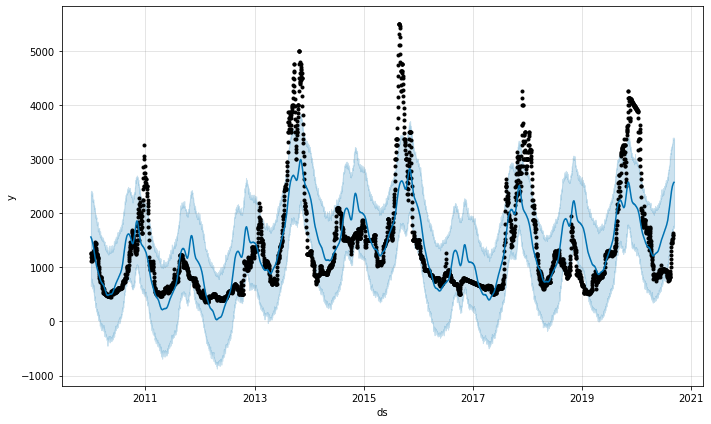

In [92]:
fig1 = m.plot(forecast)

In [93]:
f2 = forecast.copy()
f2['orj'] = pd.Series(df['y'].to_numpy())
def tst(C1, C2, C, D):

    for i in range(1, len(forecast)//7-7):
        cnt = 0
        upp = 0
        low = 0
        for j in range((i-1)*7, (i)*7):
            if abs(forecast['yhat_lower'][j]-forecast['yhat_upper'][j])*C1 < abs(forecast['yhat'][j]-df['y'][len(df)-1-j]):
                cnt += 1
            if forecast['yhat'][j]-df['y'][len(df)-1-j] < 0:
                upp += 1
            else: low += 1
        if cnt >= C2:
            for j in range((i)*7, (i+1)*7):
                # current_yhat, prev_yhat_prophet, prev_yhat_f2,
                # prev_data
                # yhat_lower_curr, yhat_upper_curr
                # yhat_lower_prev, yhat_upper_prev
                # cnt
                
                # forecast['yhat_lower'][j], forecast['yhat_upper'][j],
                # forecast['yhat_lower'][j-7], forecast['yhat_upper'][j-7],

                f2['yhat'][j] = C[0] * forecast['yhat'][j] + C[1] * f2['yhat'][j-7] + C[2] * df['y'][len(df)-1-j+7] 
                if upp > low:
                    f2['yhat'][j] += D[0] * forecast['yhat_upper'][j] + D[1] * forecast['yhat_upper'][j-7]
                else:
                    f2['yhat'][j] += D[0] * forecast['yhat_lower'][j] + D[1] * forecast['yhat_lower'][j-7]
    
    f2['sqe'] = (f2['yhat'] - f2['orj'])**2
    return (f2['sqe'].sum()/len(f2['sqe']-7))**(1/2)


In [98]:
import numpy as np
X1 = np.linspace(0.1, 1, num=10)
X2 = np.linspace(0.1, 1, num=10)
X3 = np.linspace(0.1, 1, num=10)
D1 = [0.1,0.2,0.3]
D2 = [0.1,0.2,0.3]
counter = 0
rmses = []
for d1 in D1:
    for d2 in D2:    
        for x1 in X1:
            for x2 in X2:
                for x3 in X3:

                    if x1+x2+x3+d1+d2!=1:
                        continue
#                     print([x1,x2,x3],[d1,d2])
                    rmses.append(([x1,x2,x3],[d1,d2],tst(0.25,3,[x1,x2,x3],[d1,d2])))
                    

/home/siram/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/siram/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/siram/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [100]:
rmses.sort(key= lambda x: x[2])

In [101]:
rmses[:10]

[([0.5, 0.1, 0.1], [0.1, 0.2], 765.766162405707),
 ([0.4, 0.30000000000000004, 0.1], [0.1, 0.1], 766.0491317912102),
 ([0.4, 0.2, 0.1], [0.1, 0.2], 788.3937429352196),
 ([0.30000000000000004, 0.4, 0.1], [0.1, 0.1], 796.0591775490575),
 ([0.5, 0.1, 0.2], [0.1, 0.1], 797.3112825273029),
 ([0.4, 0.1, 0.1], [0.2, 0.2], 807.3197770982333),
 ([0.4, 0.1, 0.1], [0.1, 0.3], 807.8436584233141),
 ([0.30000000000000004, 0.30000000000000004, 0.1],
  [0.1, 0.2],
  818.9945205825653),
 ([0.4, 0.2, 0.2], [0.1, 0.1], 824.9168122022857),
 ([0.30000000000000004, 0.2, 0.1], [0.2, 0.2], 837.5464554184148)]

In [102]:
tst(0.25,3, [0.5, 0.1, 0.1], [0.1, 0.2])

/home/siram/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/siram/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/siram/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



765.766162405707

In [103]:
plot_plotly(m, f2)

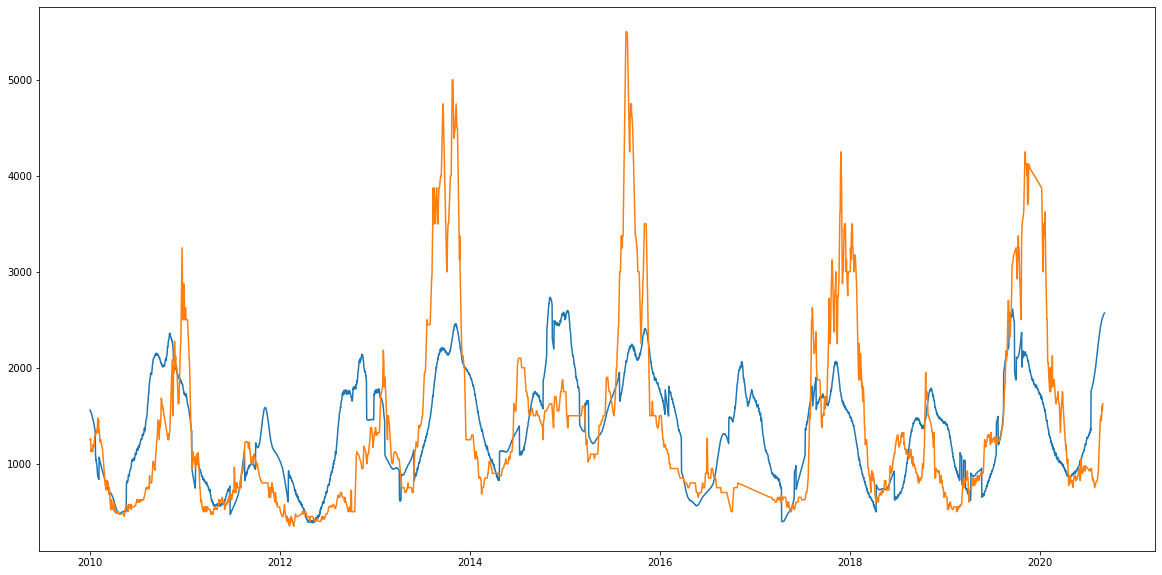

In [104]:
plt.figure(figsize=(20,10))
plt.plot(f2['ds'], f2['yhat'])
plt.plot(df['ds'], df['y'])
# plt.plot(dfl_t[i]['ds'], dfl_t[i]['y'])
plt.show()

In [75]:
f2['orj'] = pd.Series(df['y'].to_numpy())

<AxesSubplot:>

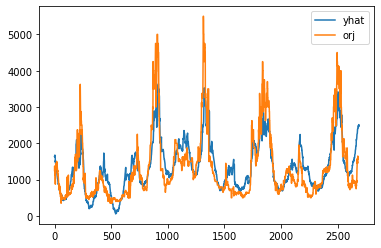

In [76]:
f2[['yhat', 'orj']].plot()

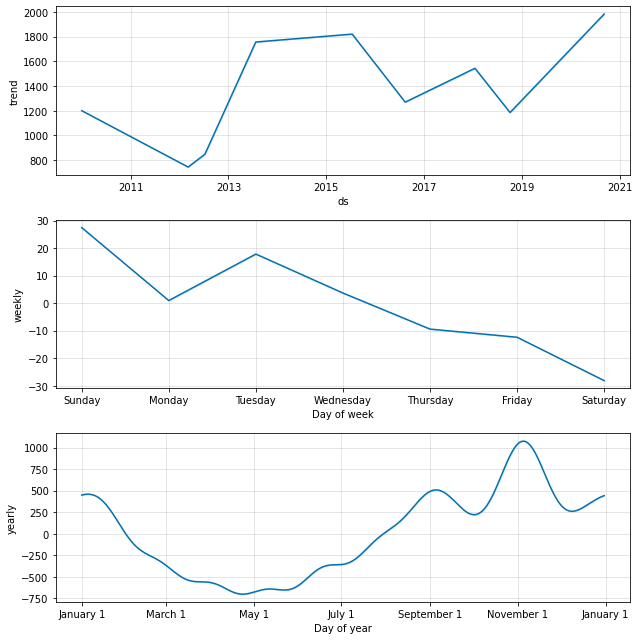

In [14]:
fig2 = m.plot_components(f2)

In [15]:
plot_plotly(m, f2)

In [16]:
plot_components_plotly(m, f2)